**Core** Libraries:

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

APDDv2 Dataset:

In [ ]:
!gdown --id 1ap5dhuEgpPC5PrJozAu2VFmUNIRZrar2 -O dataset.zip
!unzip dataset.zip -d apddv2_folder

Streaming output truncated to the last 5000 lines.
  inflating: apddv2_folder/7f28d66cc1ba471aa77b241f3fb51eb5.jpg  
  inflating: apddv2_folder/7f3a96663c7c4b2fb67d1dabd4fa04e6.jpg  
  inflating: apddv2_folder/7f3bbe42d30d47f48653e17e5ebd21b8.jpg  
  inflating: apddv2_folder/7f3bd96f38c44e839b971fafed17b396.jpg  
  inflating: apddv2_folder/7f3d500ccce74ab4bef04316a6fdf41b.png  
  inflating: apddv2_folder/7f49574980eb456db02594bb2fd7bedf.jpg  
  inflating: apddv2_folder/7f5f548aa05140fd82c8b8e0966d8a34.jpg  
  inflating: apddv2_folder/7f6c954a1ca44328986a5fc9e06d55ee.jpg  
  inflating: apddv2_folder/7f6ea5c9602344179bf0fb190d3b2ffc.jpg  
  inflating: apddv2_folder/7f71ec1931ef4ed184a26fb6e39da756.jpg  
  inflating: apddv2_folder/7f780abcd6734f43ab4f20bd6dd89d99.jpg  
  inflating: apddv2_folder/7f7925f96285491bb6c6d4f1f1e57fa7.jpg  
  inflating: apddv2_folder/7f7e52ac6e7e42dcab6c4c6b765f626b.jpg  
  inflating: apddv2_folder/7f81a150512f4446a61a41b6b52da834.jpg  
  inflating: apddv2_folde

In [ ]:
dataset_path = "./apddv2_folder"

#Check Dataset Size
num_files = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"Total Files in Dataset: {num_files}")
print("-" * 40)

# Show first 5 files per folder
for root, dirs, files in os.walk(dataset_path):
    print(f"Folder: {root}")
    for file in files[:5]:
        print(f"{file}")
    print("-" * 40)

#Show File Types
file_types = {}
for file in glob.glob(dataset_path + "/**/*", recursive=True):
    ext = os.path.splitext(file)[1]
    file_types[ext] = file_types.get(ext, 0) + 1

print("File Types Summary:")
for ext, count in file_types.items():
    print(f"{ext}: {count} files")


Total Files in Dataset: 10023
----------------------------------------
Folder: ./apddv2_folder
8588c6a85795479388b92c3172113b5c.jpg
0faa7f62638e434ebed2a692557f00c4.jpg
eceace811872433795fc0fc2ce95eed3.png
82569ec4748c40baa1ea2bfc6efc6672.jpg
265d0fc5f48f44548defa381395ceb72.jpg
----------------------------------------
File Types Summary:
.jpg: 7001 files
.png: 2768 files
.JPG: 253 files
.jpeg: 1 files


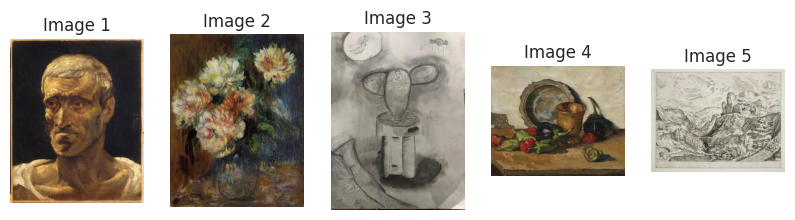

In [ ]:
image_files = glob.glob(dataset_path + "/**/*.jpg", recursive=True)[:5]

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

In [ ]:
# Load APDDv2 data
data = pd.read_csv('./apddv2_csvfiles/APDDv2-10023.csv', encoding='ISO-8859-1')
data.head()

,filename,Artistic Categories,Total aesthetic score,Theme and logic,Creativity,Layout and composition,Space and perspective,The sense of order,Light and shadow,Color,Details and texture,The overall,Mood,Language Comment
0,0000d0cd38984fffb2c04f964edc9c88.png,traditional Chinese painting*meticulous*mounta...,65.83,7.17,NaN,6.00,5.83,6.00,6.17,5.67,6.50,6.50,6.67,The composition of the picture is rigid and la...
1,000ce20bcec24f29815a9496bf314c11.jpg,sketching*classicism*still life,60.71,5.71,NaN,6.71,6.43,5.71,5.71,NaN,5.14,5.86,6.00,"Each side of the picture is good, making it a ..."
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,oil painting*romanticism*landscapes,65.00,6.20,5.6,6.20,NaN,6.80,NaN,6.60,6.40,6.60,6.40,NaN
3,00122f4a71a847a4b076756dbbf7b349.jpg,oil painting*symbolism*still life,82.86,8.29,NaN,8.29,8.57,8.00,8.29,8.29,8.14,8.14,8.57,NaN
4,00148cf2d7134849872279e21131540c.png,traditional Chinese painting*meticulous*mounta...,66.67,7.67,NaN,6.67,7.00,6.67,7.17,7.00,7.00,6.67,6.17,"The composition is full, the details are rich,..."


In [ ]:
columns_to_drop = data.columns[[3,4,6,7,10,11,12]]
data = data.drop(columns=columns_to_drop)
data.head()

,filename,Artistic Categories,Total aesthetic score,Layout and composition,Light and shadow,Color,Language Comment
0,0000d0cd38984fffb2c04f964edc9c88.png,traditional Chinese painting*meticulous*mounta...,65.83,6.00,6.17,5.67,The composition of the picture is rigid and la...
1,000ce20bcec24f29815a9496bf314c11.jpg,sketching*classicism*still life,60.71,6.71,5.71,NaN,"Each side of the picture is good, making it a ..."
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,oil painting*romanticism*landscapes,65.00,6.20,NaN,6.60,NaN
3,00122f4a71a847a4b076756dbbf7b349.jpg,oil painting*symbolism*still life,82.86,8.29,8.29,8.29,NaN
4,00148cf2d7134849872279e21131540c.png,traditional Chinese painting*meticulous*mounta...,66.67,6.67,7.17,7.00,"The composition is full, the details are rich,..."


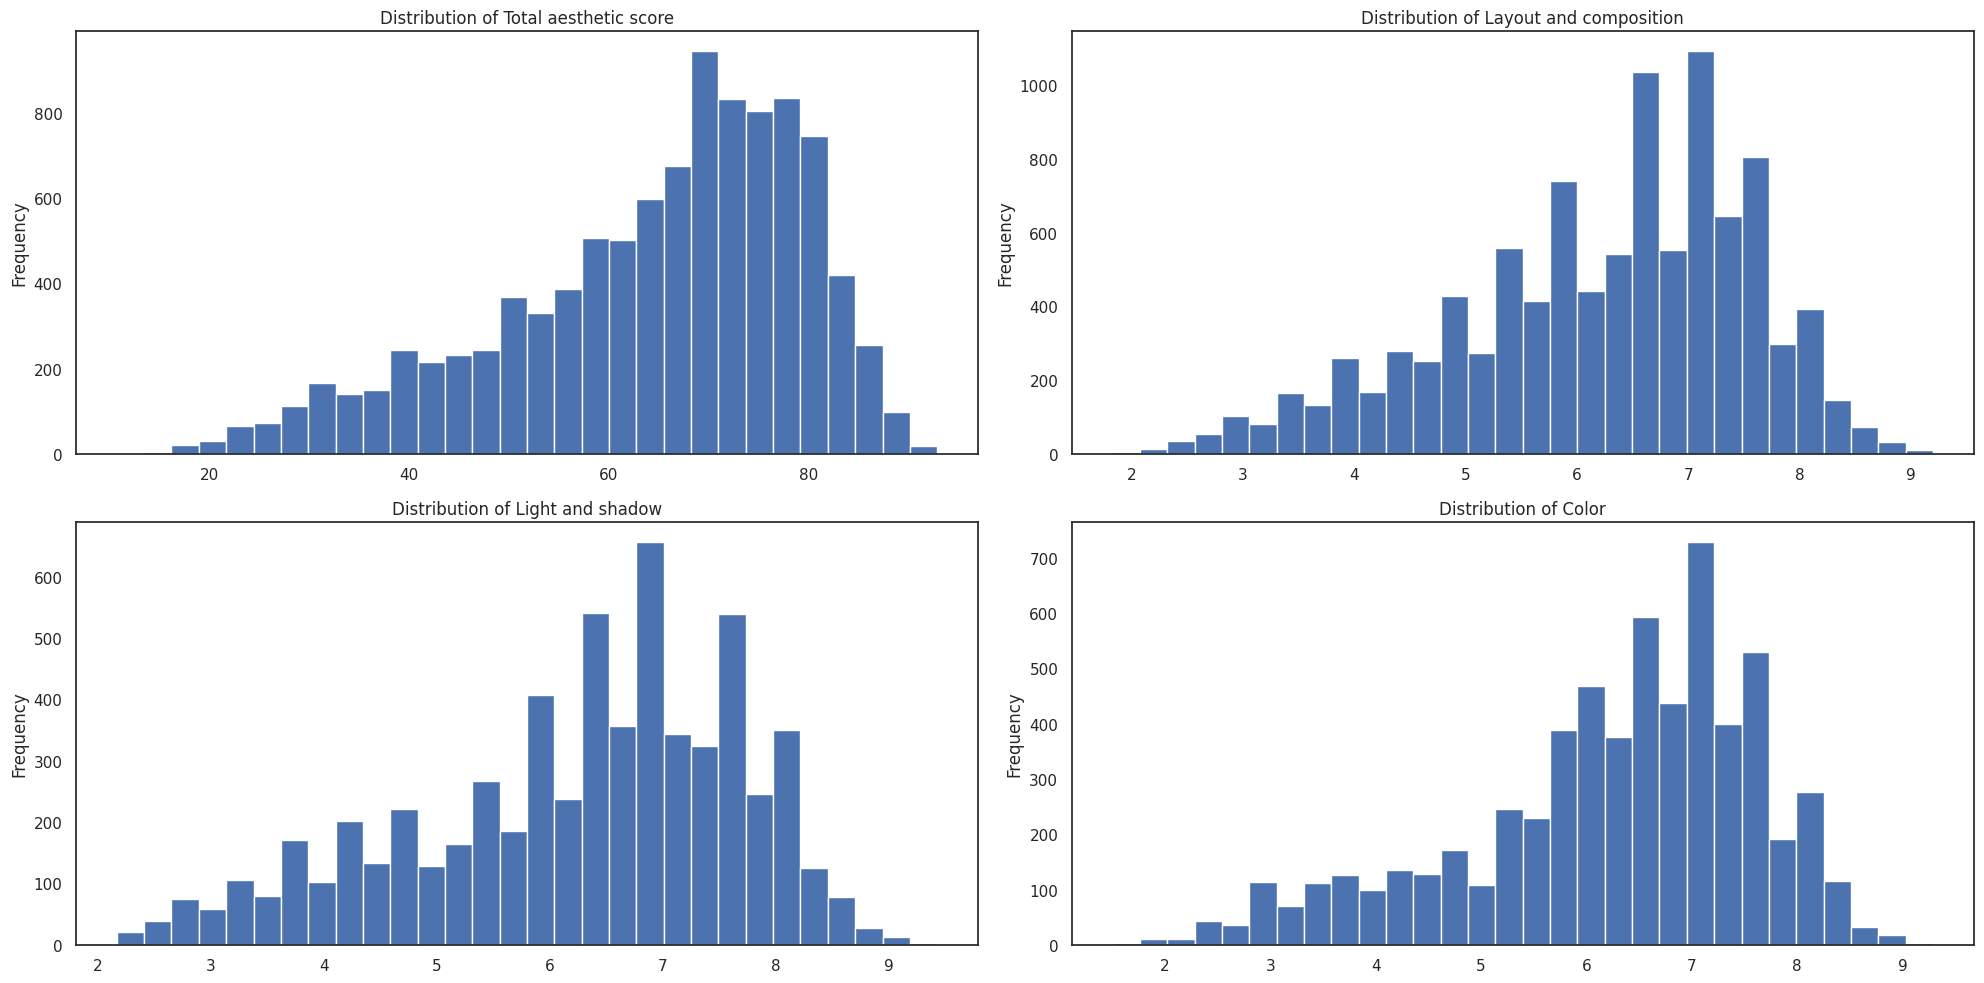

In [ ]:
#visualize the distribution of the scores
score_columns = data.columns[2:6]
plt.figure(figsize=(20, 10))
for i, col in enumerate(score_columns, 1):
    plt.subplot(2, 2, i)
    data[col].plot(kind='hist', bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [ ]:
# Check for missing values
print(f"data:\n{data.isnull().sum()}\n")
print("-" * 40)

# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for _, row in dataframe.iterrows():
        filename = f"{row['filename']}"
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames = find_invalid_filenames(data, dataset_path)
print(f"Number of invalid files: {len(invalid_filenames)}")

data:
filename                     0
Artistic Categories          0
Total aesthetic score        0
Layout and composition       0
Light and shadow          3819
Color                     3822
Language Comment          5117
dtype: int64

----------------------------------------
Number of invalid files: 0


In [ ]:
data['has_color'] = data['Color'].notnull().astype(int)

data['has_light_shadow'] = data['Light and shadow'].notnull().astype(int)

data['has_comment'] = data['Language Comment'].notnull().astype(int)

data.head()

,filename,Artistic Categories,Total aesthetic score,Layout and composition,Light and shadow,Color,Language Comment,has_color,has_light_shadow,has_comment
0,0000d0cd38984fffb2c04f964edc9c88.png,traditional Chinese painting*meticulous*mounta...,65.83,6.00,6.17,5.67,The composition of the picture is rigid and la...,1,1,1
1,000ce20bcec24f29815a9496bf314c11.jpg,sketching*classicism*still life,60.71,6.71,5.71,NaN,"Each side of the picture is good, making it a ...",0,1,1
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,oil painting*romanticism*landscapes,65.00,6.20,NaN,6.60,NaN,1,0,0
3,00122f4a71a847a4b076756dbbf7b349.jpg,oil painting*symbolism*still life,82.86,8.29,8.29,8.29,NaN,1,1,0
4,00148cf2d7134849872279e21131540c.png,traditional Chinese painting*meticulous*mounta...,66.67,6.67,7.17,7.00,"The composition is full, the details are rich,...",1,1,1


In [ ]:
data.loc[data['has_color'] == 0, 'Color'] = -1

data.loc[data['has_light_shadow'] == 0, 'Light and shadow'] = -1

data.loc[data['has_comment'] == 0, 'Language Comment'] = ""

# Check again for missing values
print(f"data:\n{data.isnull().sum()}\n")
print("-" * 40)
data.head()

data:
filename                  0
Artistic Categories       0
Total aesthetic score     0
Layout and composition    0
Light and shadow          0
Color                     0
Language Comment          0
has_color                 0
has_light_shadow          0
has_comment               0
dtype: int64

----------------------------------------


,filename,Artistic Categories,Total aesthetic score,Layout and composition,Light and shadow,Color,Language Comment,has_color,has_light_shadow,has_comment
0,0000d0cd38984fffb2c04f964edc9c88.png,traditional Chinese painting*meticulous*mounta...,65.83,6.00,6.17,5.67,The composition of the picture is rigid and la...,1,1,1
1,000ce20bcec24f29815a9496bf314c11.jpg,sketching*classicism*still life,60.71,6.71,5.71,-1.00,"Each side of the picture is good, making it a ...",0,1,1
2,000d472bde3c4f4c8dc9f66fede4d463.jpg,oil painting*romanticism*landscapes,65.00,6.20,-1.00,6.60,,1,0,0
3,00122f4a71a847a4b076756dbbf7b349.jpg,oil painting*symbolism*still life,82.86,8.29,8.29,8.29,,1,1,0
4,00148cf2d7134849872279e21131540c.png,traditional Chinese painting*meticulous*mounta...,66.67,6.67,7.17,7.00,"The composition is full, the details are rich,...",1,1,1


In [ ]:
# Split the data into training, validation and testing sets (80% train, 10% validation, 10% test)
train_data, data_temp = train_test_split(data, test_size=0.20, random_state=42, stratify=data['Artistic Categories'])
valid_data, test_data = train_test_split(data_temp, test_size=1/2, random_state=42, stratify=data_temp['Artistic Categories'])
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(8018, 10)
(1002, 10)
(1003, 10)


In [ ]:
class apddv2Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = self.dataframe.iloc[idx][['Total aesthetic score', 'Layout and composition', 'Light and shadow', 'Color']].values.astype(np.float32)
        labels = torch.tensor(labels)
        comment = self.dataframe.iloc[idx]['Language Comment']
        return image, labels, comment

In [ ]:
# CLIP normalize
IMAGE_NET_MEAN = [0.48145466, 0.4578275, 0.40821073]
IMAGE_NET_STD = [0.26862954, 0.26130258, 0.27577711]
normalize = transforms.Normalize(
    mean=IMAGE_NET_MEAN,
    std=IMAGE_NET_STD
)
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    normalize
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
# Create datasets and dataloaders
train_dataset = apddv2Dataset(train_data, dataset_path, transform=train_transform)
valid_dataset = apddv2Dataset(valid_data, dataset_path, transform=valid_transform)
test_dataset = apddv2Dataset(test_data, dataset_path, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

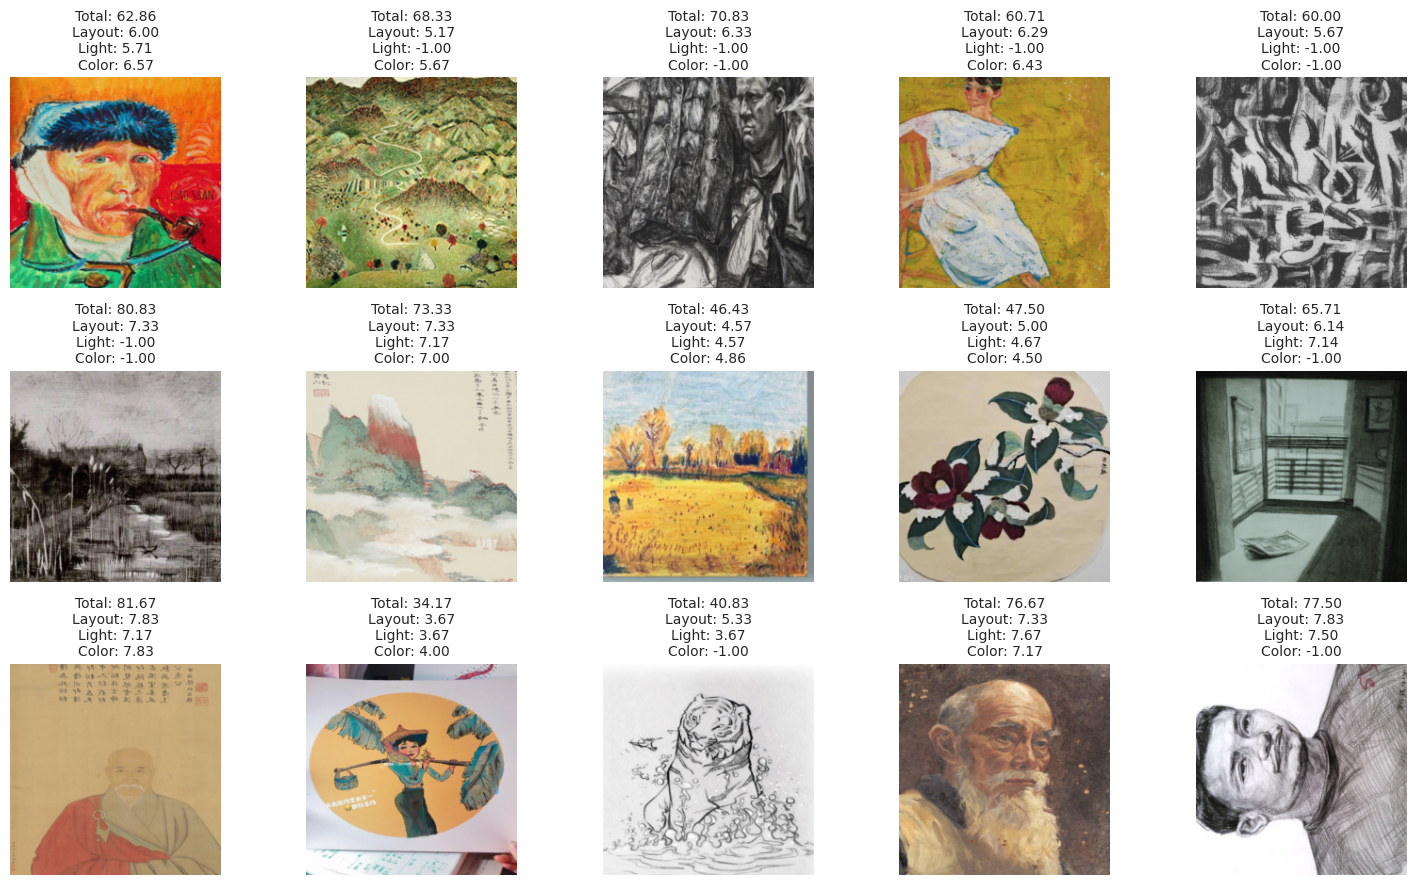

In [ ]:
# Denormalize Before Displaying
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    if isinstance(tensor, np.ndarray):
      tensor = torch.tensor(tensor)
    return tensor * std + mean

# Visualize some training images
images, labels, comments = next(iter(train_loader))
plt.figure(figsize=(15, 9))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    img = denormalize(img, IMAGE_NET_MEAN, IMAGE_NET_STD)
    img = img.numpy()
    plt.imshow(img)
    plt.title(f"Total: {labels[i][0]:.2f}\nLayout: {labels[i][1]:.2f}\nLight: {labels[i][2]:.2f}\nColor: {labels[i][3]:.2f}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()